In [6]:
from __future__ import division

import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest

import numpy as np
import pandas as pd
import collections
import math

from sklearn import metrics
from random import randint
from matplotlib import style

import seaborn as sns

style.use('fivethirtyeight')
%matplotlib inline

In [7]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [8]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']

df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [9]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [11]:
df.timestamp = df.timestamp.str.replace('[', '')
df.timestamp = df.timestamp.str.replace(']', '')
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')
df = df.tz_localize('utc').tz_convert('America/Chicago')

In [12]:
df.tail()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-17 07:55:14-05:00,97.105.19.58,"""GET /api/v1/sales?page=71 HTTP/1.1""",200,510166,NaN,"""python-requests/2.21.0"""
2019-04-21 05:02:41-05:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0
2019-04-17 14:36:41-05:00,95.31.16.121,GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2019-04-18 14:42:41-05:00,97.105.15.120,GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0
2019-04-19 14:42:41-05:00,97.105.19.58,GET /api/v1/sales?page=79/HTTP/1.1,200,2056327,NaN,python-requests/2.21.0


In [13]:
df.request_method = df.request_method.str.replace('"', '')
df.request_agent = df.request_agent.str.replace('"', '')
df.destination = df.destination.str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 14:34:42-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 14:34:42-05:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 14:34:44-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 14:34:46-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 14:34:48-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [14]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [15]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 14:34:42-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 14:34:42-05:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 14:34:44-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 14:34:46-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 14:34:48-05:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [16]:
df.destination.value_counts(dropna=False)

NaN                                                             13953
https://python.zach.lol/                                            4
https://ds.codeup.com/8.3_Acquire/                                  3
https://python.zach.lol/api/v1/stores?page=1                        2
https://python.zach.lol/api/v1/                                     2
https://python.zach.lol/api/v1/helloclass!                          1
http://localhost:8888/notebooks/acquire.ipynb                       1
https://python.zach.lol/api/v1//api/v1/items?page=2                 1
https://python.zach.lol/api/v1/items?page=0                         1
https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!                    1
https://python.zach.lol/api/v1//api/v1/items                        1
https://python.zach.lol/api/v1/stores?page=0                        1
https://python.zach.lol/api/V1/HiZach!                              1
https://python.zach.lol/api/v1/items                                1
https://python.zach.

In [17]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [18]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['size_mb'].resample('30T').median()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

In [19]:
df_ts_size.head()

2019-04-16 14:30:00-05:00    0.486491
2019-04-16 15:00:00-05:00    0.486506
2019-04-16 15:30:00-05:00    0.486503
2019-04-16 16:00:00-05:00    0.486506
2019-04-16 16:30:00-05:00    0.486509
Freq: 30T, Name: size_mb, dtype: float64

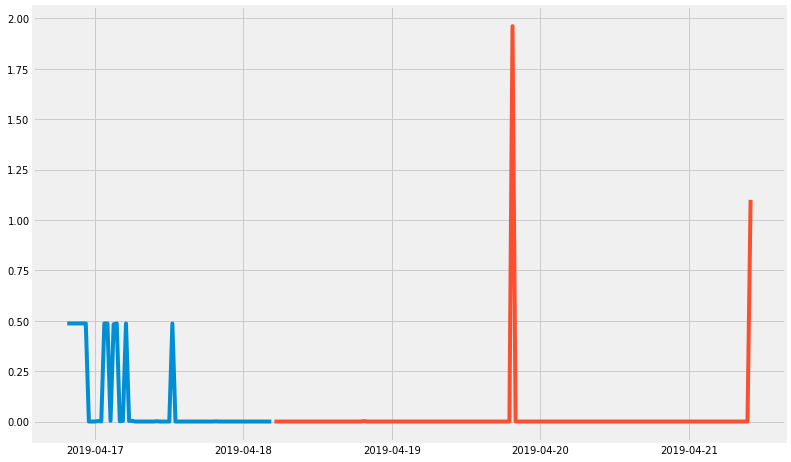

In [20]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2019-04-17 23:59:00'
start_date_test = '2019-04-18 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:]

plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

In [21]:
short_rolling = train.rolling(window=12).mean()
long_rolling = train.rolling(window=24).mean()

Text(0, 0.5, 'Size (MB)')

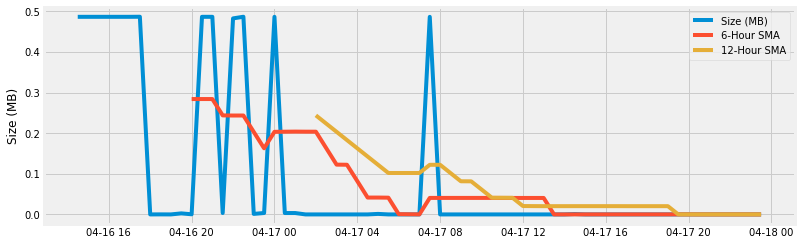

In [22]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

In [23]:
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2019-04-16 14:30:00-05:00    0.486491
2019-04-16 15:00:00-05:00    0.486492
2019-04-16 15:30:00-05:00    0.486493
Freq: 30T, Name: size_mb, dtype: float64

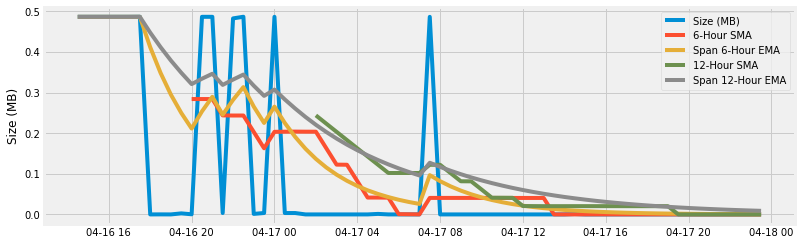

In [24]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))

In [25]:
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

In [26]:
### compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

### compute upper band and lower band using IQR with weight of 3

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

### adding .1 to the IQR so the we don't end up with a denominator of 0. 
ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [27]:
yhat.head()

,actual,moving_avg_forecast,error,pct_b
2019-04-18 00:00:00-05:00,0.0,0.00884,0.00884,0.485267
2019-04-18 00:30:00-05:00,0.0,0.00884,0.00884,0.485267
2019-04-18 01:00:00-05:00,0.0,0.00884,0.00884,0.485267
2019-04-18 01:30:00-05:00,0.0,0.00884,0.00884,0.485267
2019-04-18 02:00:00-05:00,0.0,0.00884,0.00884,0.485267


In [28]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2019-04-19 14:30:00-05:00,1.961066,0.00884,1.952227,3.753711
2019-04-21 05:00:00-05:00,1.099591,0.00884,1.090752,2.317920


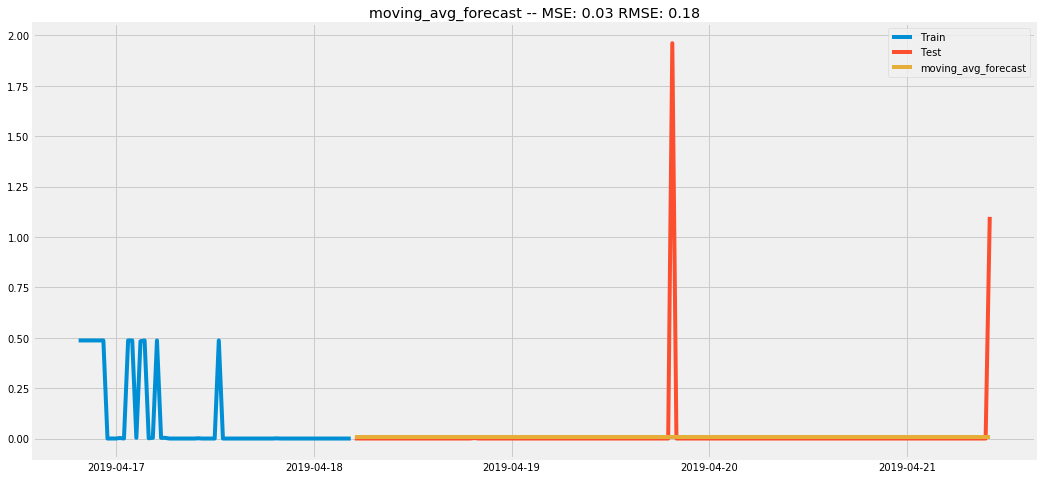

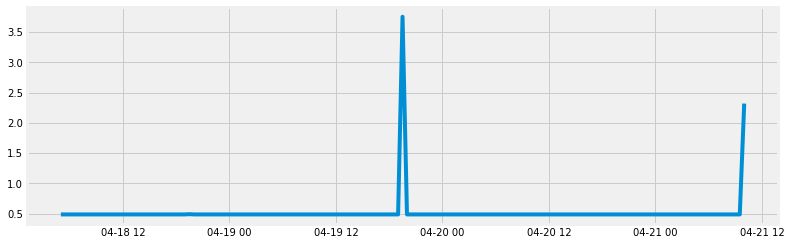

In [29]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Detecting Anomalies of Continuous Variables with Time Series Using Statistical Methods

In [100]:
import numpy as np
import pandas

df = pandas.read_table('/Users/ericescalante/Desktop/CodeUp/Codeup_Classification/time_series/anonymized-curriculum-access.txt',\
                       delim_whitespace=True,\
                       names=('date', 'time', 'page', 'cohort_id', 'person_id', 'ip'),\
                       engine='python',
                       na_values='"-"',
                       header=None,
                       index_col=False,) 

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233528 entries, 0 to 233527
Data columns (total 6 columns):
date         233528 non-null object
time         233528 non-null object
page         233528 non-null object
cohort_id    233528 non-null int64
person_id    233392 non-null object
ip           219206 non-null object
dtypes: int64(1), object(5)
memory usage: 10.7+ MB


In [102]:
df.shape

(233528, 6)

In [103]:
df['timestamp'] = df['date'].map(str) + ' ' + df['time']
df.timestamp= pd.to_datetime(df.timestamp) 
df = df.set_index('timestamp')

In [104]:
df['cohort_id'] = pd.to_numeric(df['cohort_id'])

In [105]:
del df['date']
del df['time']

In [106]:
df.head()

,page,cohort_id,person_id,ip
timestamp,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [109]:
df.groupby('cohort_id').max()

,page
cohort_id,
1,uploads/58a217a705bde.jpg
2,spring/setup
3,spring/setup
4,slides/syntax_types_and_variables
5,spring/setup
6,spring/setup
7,toc
8,slides/syntax_types_and_variables
9,spring/setup
